In [ ]:
!pip install torch transformers datasets tqdm numpy scikit-learn matplotlib seaborn pandas numpy

In [ ]:
!nvidia-smi

Mon Dec  8 11:08:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from datasets import load_dataset
from tqdm import tqdm

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {DEVICE}")

class WikiAutoAssetDataset(Dataset):
    def __init__(self, split="train", tokenizer_name="roberta-base", max_length=128, debug=False, max_samples=None):
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length
        self.split = split

        # Load dataset
        try:
            self.dataset = load_dataset("GEM/wiki_auto_asset_turk", split=split)
        except Exception as e:
            print(f"Error loading dataset: {e}")
            raise e

        # Logic for limiting dataset size
        if debug:
            print("DEBUG MODE: Limiting to 1,000 samples.")
            self.dataset = self.dataset.select(range(1000))
        elif max_samples is not None:
            print(f"SUBSET MODE: Limiting to {max_samples} samples.")
            # Use 'select' to grab the first N samples
            # Ensure we don't ask for more than exists
            limit = min(len(self.dataset), max_samples)
            self.dataset = self.dataset.select(range(limit))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        complex_text = item['source']

        if self.split == 'train':
            simple_text = item['target']
        else:
            if 'references' in item and len(item['references']) > 0:
                simple_text = item['references'][0]
            elif 'target' in item:
                simple_text = item['target']
            else:
                simple_text = ""

        return complex_text, simple_text

    def collate_fn(self, batch):
        complex_texts, simple_texts = zip(*batch)
        complex_encodings = self.tokenizer(list(complex_texts), padding=True, truncation=True, max_length=self.max_length, return_tensors="pt")
        simple_encodings = self.tokenizer(list(simple_texts), padding=True, truncation=True, max_length=self.max_length, return_tensors="pt")
        return complex_encodings, simple_encodings

class JEPA_Simplifier(nn.Module):
    def __init__(self, model_name="roberta-base", temp=0.07):
        super(JEPA_Simplifier, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.hidden_size = 768

        # Predictor: Maps Complex-Latent -> Simple-Latent
        self.predictor = nn.Sequential(
            nn.Linear(self.hidden_size, 512),
            nn.ReLU(),
            nn.Linear(512, self.hidden_size)
        )
        self.temp = temp # Temperature for InfoNCE

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output.last_hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def forward(self, complex_input, simple_input=None):
        # 1. Encode Complex (Source)
        complex_output = self.encoder(**complex_input)
        z_complex = self.mean_pooling(complex_output, complex_input['attention_mask'])

        # 2. Predict Simple Representation
        z_pred = self.predictor(z_complex)

        loss = None
        z_simple = None

        if simple_input is not None:
            # 3. Encode Simple (Target) - The Ground Truth
            # Optional: Use torch.no_grad() here if you want to freeze the target encoder (Stop-Gradient)
            # which is common in JEPA architectures to stabilize training.
            simple_output = self.encoder(**simple_input)
            z_simple = self.mean_pooling(simple_output, simple_input['attention_mask'])

            # --- INFO-NCE / CONTRASTIVE LOSS ---
            # Normalize vectors for cosine similarity
            z_pred_norm = nn.functional.normalize(z_pred, dim=1)
            z_simple_norm = nn.functional.normalize(z_simple, dim=1)

            # Compute similarity matrix (Batch_Size x Batch_Size)
            # Diagonals are the positive pairs (Complex_i -> Simple_i)
            # Off-diagonals are negative pairs (Complex_i -> Simple_j)
            logits = torch.matmul(z_pred_norm, z_simple_norm.T) / self.temp

            # Labels: The correct match for the i-th complex input is the i-th simple target
            labels = torch.arange(logits.size(0)).to(logits.device)

            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return loss, z_pred, z_simple


Using device: cuda


In [ ]:
def train(epochs=2, batch_size=32, lr=2e-5, debug=False, max_samples=50000, save_path="jepa_simplifier_subset.pth"):

    print(f"Initializing DataLoaders (Max Samples={max_samples})...")
    # PASS max_samples HERE
    train_dataset = WikiAutoAssetDataset(split='train', debug=debug, max_samples=max_samples)
    val_dataset = WikiAutoAssetDataset(split='validation', debug=debug) # Keep val small or full, doesn't matter much

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=val_dataset.collate_fn)

    # 2. Initialize Model
    print("Initializing Model...")
    model = JEPA_Simplifier(model_name="roberta-base")
    model.to(DEVICE)

    # 3. Setup Optimizer & Scheduler
    optimizer = AdamW(model.parameters(), lr=lr)

    num_training_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * num_training_steps),
        num_training_steps=num_training_steps
    )

    print(f"Starting training on {DEVICE}...")

    # 4. Training Loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        # Progress bar for the epoch
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for complex_inputs, simple_inputs in progress_bar:
            # Move to device
            complex_inputs = {k: v.to(DEVICE) for k, v in complex_inputs.items()}
            simple_inputs = {k: v.to(DEVICE) for k, v in simple_inputs.items()}

            optimizer.zero_grad()

            # Forward pass
            loss, _, _ = model(complex_inputs, simple_inputs)

            # Backward pass
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} Summary - Avg Loss: {avg_train_loss:.4f}")

        # 5. Run Validation
        validate(model, val_loader)

    # 6. Save Model
    if not debug:
        print(f"Saving model to {save_path}...")
        torch.save(model.state_dict(), save_path)
    else:
        print("Debug mode: Model not saved.")

def validate(model, val_loader):
    model.eval()
    total_cosine_sim = 0
    cosine_loss_fct = nn.CosineSimilarity(dim=1)

    print("Running validation...")
    with torch.no_grad():
        for complex_inputs, simple_inputs in tqdm(val_loader, desc="Validation", leave=False):
            complex_inputs = {k: v.to(DEVICE) for k, v in complex_inputs.items()}
            simple_inputs = {k: v.to(DEVICE) for k, v in simple_inputs.items()}

            _, z_pred, z_simple = model(complex_inputs, simple_inputs)

            # Calculate Cosine Similarity between Prediction and Target
            similarity = cosine_loss_fct(z_pred, z_simple)
            total_cosine_sim += similarity.mean().item()

    avg_cosine_sim = total_cosine_sim / len(val_loader)
    print(f"Validation Cosine Similarity: {avg_cosine_sim:.4f}")

In [ ]:
train(
    epochs=2,
    batch_size=32,
    debug=False,
    max_samples=25000,
    save_path="jepa.pth"
)

Initializing DataLoaders (Max Samples=25000)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

wiki_auto_asset_turk/train-00000-of-0000(…):   0%|          | 0.00/89.5M [00:00<?, ?B/s]

wiki_auto_asset_turk/validation-00000-of(…):   0%|          | 0.00/1.91M [00:00<?, ?B/s]

wiki_auto_asset_turk/test_asset-00000-of(…):   0%|          | 0.00/204k [00:00<?, ?B/s]

wiki_auto_asset_turk/test_turk-00000-of-(…):   0%|          | 0.00/174k [00:00<?, ?B/s]

wiki_auto_asset_turk/test_contract-00000(…):   0%|          | 0.00/194k [00:00<?, ?B/s]

wiki_auto_asset_turk/test_wiki-00000-of-(…):   0%|          | 0.00/180k [00:00<?, ?B/s]

wiki_auto_asset_turk/challenge_train_sam(…):   0%|          | 0.00/123k [00:00<?, ?B/s]

wiki_auto_asset_turk/challenge_validatio(…):   0%|          | 0.00/90.1k [00:00<?, ?B/s]

wiki_auto_asset_turk/challenge_test_asse(…):   0%|          | 0.00/186k [00:00<?, ?B/s]

wiki_auto_asset_turk/challenge_test_asse(…):   0%|          | 0.00/187k [00:00<?, ?B/s]

wiki_auto_asset_turk/challenge_test_asse(…):   0%|          | 0.00/188k [00:00<?, ?B/s]

wiki_auto_asset_turk/challenge_test_asse(…):   0%|          | 0.00/186k [00:00<?, ?B/s]

wiki_auto_asset_turk/challenge_test_turk(…):   0%|          | 0.00/174k [00:00<?, ?B/s]

wiki_auto_asset_turk/challenge_test_turk(…):   0%|          | 0.00/176k [00:00<?, ?B/s]

wiki_auto_asset_turk/challenge_test_turk(…):   0%|          | 0.00/177k [00:00<?, ?B/s]

wiki_auto_asset_turk/challenge_test_turk(…):   0%|          | 0.00/174k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/483801 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating test_asset split:   0%|          | 0/359 [00:00<?, ? examples/s]

Generating test_turk split:   0%|          | 0/359 [00:00<?, ? examples/s]

Generating test_contract split:   0%|          | 0/659 [00:00<?, ? examples/s]

Generating test_wiki split:   0%|          | 0/720 [00:00<?, ? examples/s]

Generating challenge_train_sample split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating challenge_validation_sample split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating challenge_test_asset_backtranslation split:   0%|          | 0/359 [00:00<?, ? examples/s]

Generating challenge_test_asset_bfp02 split:   0%|          | 0/359 [00:00<?, ? examples/s]

Generating challenge_test_asset_bfp05 split:   0%|          | 0/359 [00:00<?, ? examples/s]

Generating challenge_test_asset_nopunc split:   0%|          | 0/359 [00:00<?, ? examples/s]

Generating challenge_test_turk_backtranslation split:   0%|          | 0/359 [00:00<?, ? examples/s]

Generating challenge_test_turk_bfp02 split:   0%|          | 0/359 [00:00<?, ? examples/s]

Generating challenge_test_turk_bfp05 split:   0%|          | 0/359 [00:00<?, ? examples/s]

Generating challenge_test_turk_nopunc split:   0%|          | 0/359 [00:00<?, ? examples/s]

SUBSET MODE: Limiting to 25000 samples.
Initializing Model...


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training on cuda...


Epoch 1/2: 100%|██████████| 782/782 [10:14<00:00,  1.27it/s, loss=0.0427]


Epoch 1 Summary - Avg Loss: 0.6652
Running validation...


Validation Cosine Similarity: 0.6892


Epoch 2/2: 100%|██████████| 782/782 [10:15<00:00,  1.27it/s, loss=0.0151]


Epoch 2 Summary - Avg Loss: 0.1149
Running validation...


Validation Cosine Similarity: 0.7258
Saving model to jepa.pth...


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd

def visualize_latents(model, val_loader, num_samples=200, perplexity=30):
    """
    Runs t-SNE to visualize Content vs. Style disentanglement.

    Args:
        num_samples (int): How many sentence pairs to visualize (don't make this too huge).
        perplexity (int): t-SNE hyperparameter (5-50 is typical).
    """
    model.eval()

    # Store vectors and labels
    vectors = []
    style_labels = []
    content_labels = [] # To track which sentence pair it belongs to

    print(f"Extracting embeddings for {num_samples} samples...")

    count = 0
    with torch.no_grad():
        for complex_inputs, simple_inputs in val_loader:
            if count >= num_samples:
                break

            # Move to device
            complex_inputs = {k: v.to(DEVICE) for k, v in complex_inputs.items()}
            simple_inputs = {k: v.to(DEVICE) for k, v in simple_inputs.items()}

            # Forward pass
            # Note: We need the raw outputs, so we call the internal components if needed
            # But your model returns z_pred and z_simple directly
            loss, z_pred, z_simple = model(complex_inputs, simple_inputs)

            # We also need z_complex (the input style) to see the starting point
            complex_output = model.encoder(**complex_inputs)
            z_complex = model.mean_pooling(complex_output, complex_inputs['attention_mask'])

            batch_size = z_complex.size(0)

            # Collect data for this batch
            for i in range(batch_size):
                if count >= num_samples:
                    break

                # 1. Complex Representation (Input)
                vectors.append(z_complex[i].cpu().numpy())
                style_labels.append("Complex (Input)")
                content_labels.append(count)

                # 2. Simple Representation (Target)
                vectors.append(z_simple[i].cpu().numpy())
                style_labels.append("Simple (Target)")
                content_labels.append(count)

                # 3. Predicted Representation (Output)
                vectors.append(z_pred[i].cpu().numpy())
                style_labels.append("Predicted (Output)")
                content_labels.append(count)

                count += 1

    # Convert to numpy
    X = np.array(vectors)

    # Run t-SNE
    print("Running t-SNE (this might take a moment)...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, init='pca', learning_rate='auto')
    X_embedded = tsne.fit_transform(X)

    # Create DataFrame for plotting
    df = pd.DataFrame({
        'x': X_embedded[:, 0],
        'y': X_embedded[:, 1],
        'Style': style_labels,
        'Content_ID': content_labels
    })

    # --- PLOT 1: Style Separation ---
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.scatterplot(data=df, x='x', y='y', hue='Style', alpha=0.7, palette={'Complex (Input)': 'red', 'Simple (Target)': 'blue', 'Predicted (Output)': 'green'})
    plt.title("Latent Space by STYLE\n(Goal: Green should overlap Blue, away from Red)")
    plt.legend(title='Style')

    # --- PLOT 2: Content Alignment ---
    # We only plot a few specific sentences to avoid clutter
    subset_ids = list(range(10)) # Plot first 10 sentence pairs
    df_subset = df[df['Content_ID'].isin(subset_ids)]

    plt.subplot(1, 2, 2)
    sns.scatterplot(data=df_subset, x='x', y='y', hue='Content_ID', style='Style', palette="tab10", s=100)
    plt.title("Latent Space by CONTENT (First 10 Pairs)\n(Goal: Shapes for same Color should cluster)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successfully loaded model from jepa.pth
Preparing validation data...
DEBUG MODE: Limiting to 1,000 samples.
Extracting embeddings for 200 samples...
Running t-SNE (this might take a moment)...


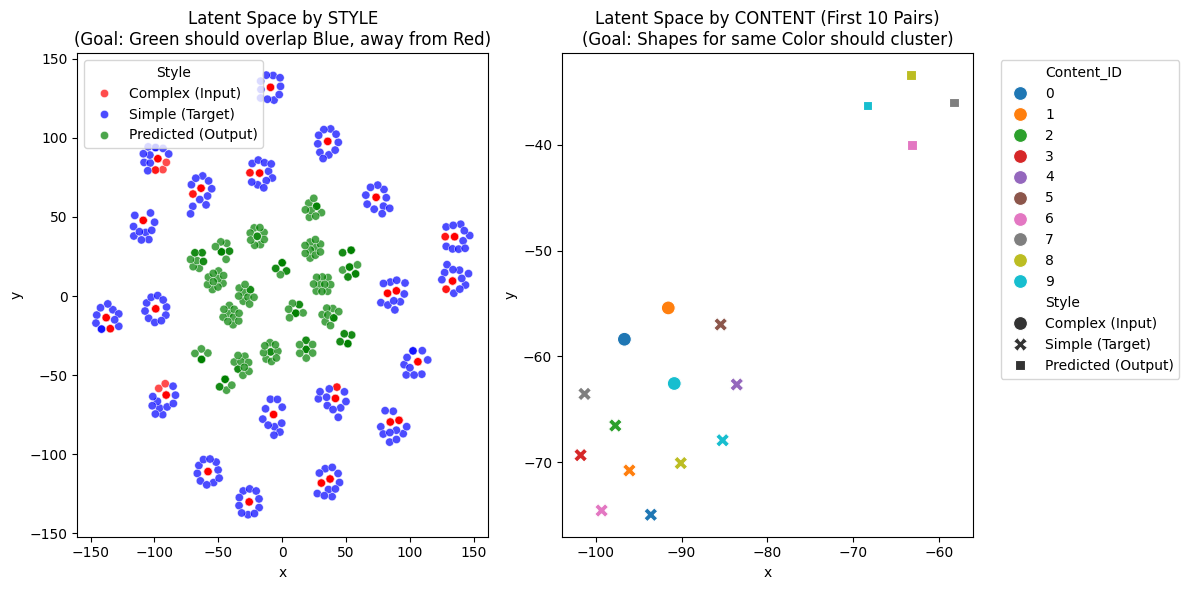

In [ ]:
import torch
from torch.utils.data import DataLoader

# 1. Initialize the Architecture
# We must create a fresh instance of the model class first
loaded_model = JEPA_Simplifier(model_name="roberta-base")

# 2. Load the Saved Weights
save_path = "jepa.pth"

try:
    # map_location ensures it loads correctly even if you switch between GPU/CPU
    loaded_model.load_state_dict(torch.load(save_path, map_location=DEVICE))
    print(f"Successfully loaded model from {save_path}")
except FileNotFoundError:
    print(f"Error: Could not find {save_path}. Did you run the 'train()' function first?")

# 3. Move to Device & Set to Eval Mode
loaded_model.to(DEVICE)
loaded_model.eval()

# 4. Prepare Validation Data (using Debug for speed, set debug=False for full quality)
print("Preparing validation data...")
val_dataset = WikiAutoAssetDataset(split='validation', debug=True)
val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=val_dataset.collate_fn
)

# 5. Generate the Plots
# You can increase num_samples to 500 or 1000 for a denser plot if you have time
visualize_latents(loaded_model, val_loader, num_samples=200, perplexity=30)

In [ ]:
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader

#
# Logic: We train a classifier on Original Embeddings, then test it on your JEPA Predictions.

def run_probing_evaluation(model, val_loader):
    model.eval()

    # Storage
    X_complex = [] # Original Complex (Style + Content)
    X_simple = []  # Original Simple (Content only)
    X_pred = []    # JEPA Output (Should be Content only)

    print("Extracting embeddings for Probing...")

    with torch.no_grad():
        for complex_inputs, simple_inputs in tqdm(val_loader, desc="Extracting"):
            complex_inputs = {k: v.to(DEVICE) for k, v in complex_inputs.items()}
            simple_inputs = {k: v.to(DEVICE) for k, v in simple_inputs.items()}

            # 1. Get Original Embeddings (Baselines)
            # We access the encoder directly to get the raw RoBERTa embedding
            out_c = model.encoder(**complex_inputs)
            out_s = model.encoder(**simple_inputs)

            z_c = model.mean_pooling(out_c, complex_inputs['attention_mask']).cpu().numpy()
            z_s = model.mean_pooling(out_s, simple_inputs['attention_mask']).cpu().numpy()

            # 2. Get JEPA Prediction
            # We pass complex input, get predicted simple output
            z_pred = model.predictor(torch.tensor(z_c).to(DEVICE)).cpu().numpy()

            X_complex.append(z_c)
            X_simple.append(z_s)
            X_pred.append(z_pred)

    # Concatenate all batches
    X_complex = np.concatenate(X_complex, axis=0)
    X_simple = np.concatenate(X_simple, axis=0)
    X_pred = np.concatenate(X_pred, axis=0)

    print(f"Dataset Shape: {X_complex.shape}")

    # --- PHASE 1: Train the Style Probe ---
    # Can a linear classifier distinguish Complex from Simple in the original space?
    # Label 1 = Complex, Label 0 = Simple

    X_train = np.concatenate([X_complex, X_simple], axis=0)
    y_train = np.concatenate([np.ones(len(X_complex)), np.zeros(len(X_simple))], axis=0)

    print("\nTraining Style Classifier (Logistic Regression)...")
    clf = LogisticRegression(max_iter=1000, solver='liblinear')
    clf.fit(X_train, y_train)

    # Check baseline accuracy (should be high, e.g., >80%)
    # If this is low, RoBERTa itself can't distinguish complexity (unlikely)
    baseline_acc = clf.score(X_train, y_train)
    print(f"Baseline Classifier Accuracy (Complex vs Simple): {baseline_acc:.4f}")

    # --- PHASE 2: Test the JEPA ---
    # We feed the JEPA predictions (which came from Complex inputs) into the classifier.
    # If JEPA successfully stripped style, the classifier should think these are SIMPLE (0).

    pred_labels = clf.predict(X_pred)

    # Calculate "Simplification Success Rate"
    # The percentage of predictions classified as Class 0 (Simple)
    success_rate = (pred_labels == 0).mean()

    print(f"\n--- PROBING RESULTS ---")
    print(f"Hypothesis: JEPA output should look like 'Simple' text.")
    print(f"Simplification Success Rate: {success_rate:.4f} (Higher is Better)")
    print(f"--------------------------------------------------")

    if success_rate > 0.5:
        print("✅ SUCCESS: The model is actively stripping complexity features.")
    else:
        print("❌ FAILURE: The model output still looks like 'Complex' text.")

# Load Model (Ensure no extra args here that aren't in __init__)
model = JEPA_Simplifier(model_name="roberta-base")
model.load_state_dict(torch.load("jepa.pth", map_location=DEVICE))
model.to(DEVICE)

# Data
val_dataset = WikiAutoAssetDataset(split='validation', debug=True) # Use subset for speed
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=val_dataset.collate_fn)

run_probing_evaluation(model, val_loader)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DEBUG MODE: Limiting to 1,000 samples.
Extracting embeddings for Probing...


Extracting: 100%|██████████| 32/32 [00:04<00:00,  7.42it/s]


Dataset Shape: (1000, 768)

Training Style Classifier (Logistic Regression)...
Baseline Classifier Accuracy (Complex vs Simple): 0.9465

--- PROBING RESULTS ---
Hypothesis: JEPA output should look like 'Simple' text.
Simplification Success Rate: 0.8600 (Higher is Better)
--------------------------------------------------
✅ SUCCESS: The model is actively stripping complexity features.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import shutil

source_path = 'jepa.pth'
destination_path = '/content/drive/MyDrive/jepa.pth'

# Copy the file
shutil.copy(source_path, destination_path)

print(f"File saved to: {destination_path}")

Mounted at /content/drive
File saved to: /content/drive/MyDrive/jepa.pth


In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm

def decode_by_retrieval(model, val_loader, num_examples=5):
    """
    Since we can't generate text from a vector directly without a decoder,
    we 'decode' by finding the existing Simple sentence that is closest
    to our predicted vector.
    """
    model.eval()

    # 1. Build the "Memory Bank" of all Simple Sentences in Validation
    print("Building Retrieval Bank (Encoding all simple targets)...")
    simple_bank_vecs = []
    simple_bank_texts = []

    with torch.no_grad():
        for complex_inputs, simple_inputs in tqdm(val_loader, desc="Indexing"):
            # Move simple inputs to device to get embeddings
            simple_inputs = {k: v.to(DEVICE) for k, v in simple_inputs.items()}

            # Get the "Gold Standard" Simple Embeddings
            simple_out = model.encoder(**simple_inputs)
            z_simple = model.mean_pooling(simple_out, simple_inputs['attention_mask'])

            # Store vectors and actual text
            simple_bank_vecs.append(z_simple)

            # We need to decode the TOKEN IDs back to STRING to store the text
            # We assume input_ids is in the batch
            input_ids = simple_inputs['input_ids'].cpu()
            texts = model.encoder.embeddings.word_embeddings.num_embeddings # Hack to access tokenizer? No, use tokenizer from dataset.
            # Easier: Just assume we can't access raw text unless we passed it.
            # actually, let's just use the tokenizer we have in the dataset class

            # RE-DECODE the input_ids to get the string back
            decoded_texts = val_loader.dataset.tokenizer.batch_decode(input_ids, skip_special_tokens=True)
            simple_bank_texts.extend(decoded_texts)

    # Stack all simple vectors into one big matrix
    simple_bank_matrix = torch.cat(simple_bank_vecs, dim=0) # (N_samples, 768)

    # 2. Run the Test
    print(f"\n--- RETRIEVAL DEMO (Top {num_examples}) ---")

    cosine_sim = nn.CosineSimilarity(dim=1)

    count = 0
    with torch.no_grad():
        for complex_inputs, simple_inputs in val_loader:
            if count >= num_examples:
                break

            complex_inputs = {k: v.to(DEVICE) for k, v in complex_inputs.items()}

            # Get Complex Input Text (for display)
            input_ids = complex_inputs['input_ids'].cpu()
            complex_text = val_loader.dataset.tokenizer.batch_decode(input_ids, skip_special_tokens=True)

            # Run Model: Complex -> Predicted Vector
            loss, z_pred, _ = model(complex_inputs) # z_pred is (Batch, 768)

            # For each item in the batch
            for i in range(len(z_pred)):
                if count >= num_examples:
                    break

                # Current Vector
                curr_vec = z_pred[i].unsqueeze(0) # (1, 768)

                # 3. Find Nearest Neighbor in the Bank
                # Calculate sim between this vector and ALL simple vectors
                # We use matrix multiplication for speed: (1, 768) @ (768, N) = (1, N)
                # But we need normalized vectors for cosine similarity

                curr_norm = torch.nn.functional.normalize(curr_vec, p=2, dim=1)
                bank_norm = torch.nn.functional.normalize(simple_bank_matrix, p=2, dim=1)

                # Dot product
                scores = torch.mm(curr_norm, bank_norm.transpose(0, 1))

                # Get Top 1 index
                best_score, best_idx = torch.topk(scores, k=1)
                best_idx = best_idx.item()

                print(f"\nExample {count+1}:")
                print(f"🔴 Input (Complex):  {complex_text[i]}")
                print(f"🟢 Retrieved (Pred): {simple_bank_texts[best_idx]}")
                print(f"   (Similarity: {best_score.item():.4f})")

                count += 1

# Run it
# Note: Ensure 'val_loader' is using the same tokenizer as the model
# You might need to access the tokenizer from: val_dataset.tokenizer
decode_by_retrieval(model, val_loader, num_examples=50)

Building Retrieval Bank (Encoding all simple targets)...


Indexing: 100%|██████████| 32/32 [00:02<00:00, 12.19it/s]



--- RETRIEVAL DEMO (Top 50) ---

Example 1:
🔴 Input (Complex):  Adjacent counties are Marin (to the south), Mendocino (to the north), Lake (northeast), Napa (to the east), and Solano and Contra Costa (to the southeast).
🟢 Retrieved (Pred): Adjacent counties are Marin (south), Mendocino (north), Lake (northeast), and Napa (east). Solano and Contra Costa are to the southeast.
   (Similarity: 0.7522)

Example 2:
🔴 Input (Complex):  Adjacent counties are Marin (to the south), Mendocino (to the north), Lake (northeast), Napa (to the east), and Solano and Contra Costa (to the southeast).
🟢 Retrieved (Pred): Adjacent counties are Marin (south), Mendocino (north), Lake (northeast), and Napa (east). Solano and Contra Costa are to the southeast.
   (Similarity: 0.7522)

Example 3:
🔴 Input (Complex):  Adjacent counties are Marin (to the south), Mendocino (to the north), Lake (northeast), Napa (to the east), and Solano and Contra Costa (to the southeast).
🟢 Retrieved (Pred): Adjacent counties are